In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("spotify.csv", encoding='ISO-8859-1')

In [3]:
print(df.shape)

(149860, 11)


In [4]:
print(df.columns)

Index(['spotify_track_uri', 'ts', 'platform', 'ms_played', 'track_name',
       'artist_name', 'album_name', 'reason_start', 'reason_end', 'shuffle',
       'skipped'],
      dtype='object')


In [5]:
df.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,08-07-2013 02:44,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,08-07-2013 02:45,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,08-07-2013 02:50,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,08-07-2013 02:52,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,08-07-2013 03:17,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.dropna(axis=1, how='all', inplace=True)

In [8]:
df.isnull().sum()

spotify_track_uri      0
ts                     0
platform               0
ms_played              0
track_name             0
artist_name            0
album_name             0
reason_start         143
reason_end           117
shuffle                0
skipped                0
dtype: int64

In [9]:
df['reason_start'] = df['reason_start'].fillna(df['reason_start'].mode()[0])
df['reason_end'] = df['reason_end'].fillna(df['reason_end'].mode()[0])

In [10]:
df.isnull().sum()

spotify_track_uri    0
ts                   0
platform             0
ms_played            0
track_name           0
artist_name          0
album_name           0
reason_start         0
reason_end           0
shuffle              0
skipped              0
dtype: int64

In [11]:
df['ts'] = pd.to_datetime(df['ts'], dayfirst=True)
df['year'] = df['ts'].dt.year
df['hour'] = df['ts'].dt.hour
df['dayofweek'] = df['ts'].dt.dayofweek

Which artist did they listen to the most this year? Is it the same as last year? 

Top artist each year:
      year  artist_name  play_count
18    2013   John Mayer          34
67    2014         Blur           2
630   2015   The Script         123
1066  2016  The Beatles         713
1677  2017  The Beatles        3229
2166  2018  The Beatles        2001
2644  2019  The Beatles        1993
3439  2020  The Killers        1928
4855  2021  The Beatles        1446
6164  2022  The Beatles         993
7608  2023  The Beatles         730
8710  2024  The Beatles         511


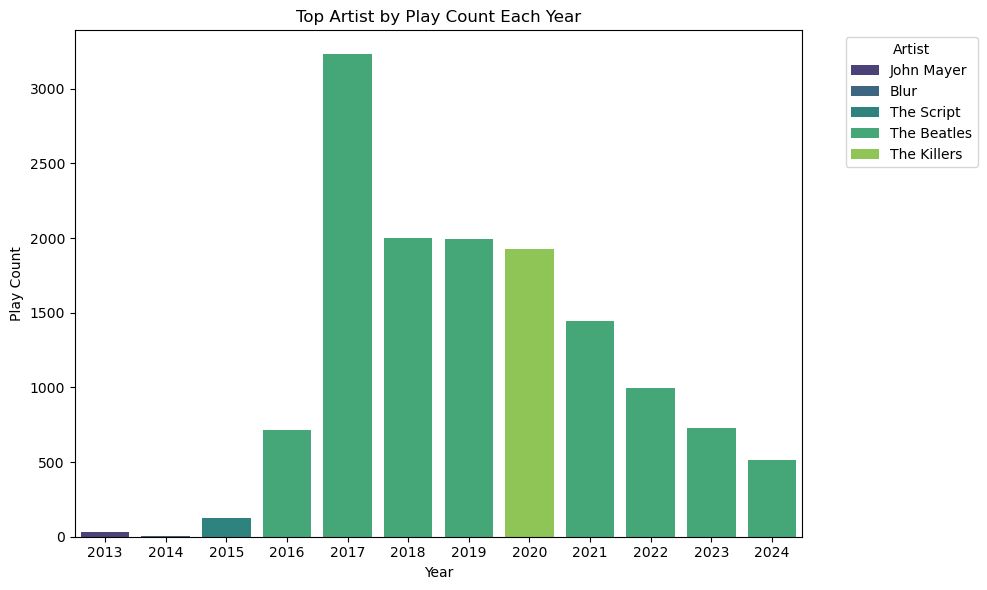

In [12]:
artist_yearly = df.groupby(['year', 'artist_name']).size().reset_index(name='play_count')
top_artist_each_year = artist_yearly.sort_values(['year', 'play_count'], ascending=[True, False]).drop_duplicates('year')

print("Top artist each year:")
print(top_artist_each_year)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_artist_each_year,
    x='year',
    y='play_count',
    hue='artist_name',
    dodge=False,
    palette='viridis'
)

plt.title("Top Artist by Play Count Each Year")
plt.xlabel("Year")
plt.ylabel("Play Count")
plt.legend(title='Artist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Which songs have they played the most? How often do they skip them?

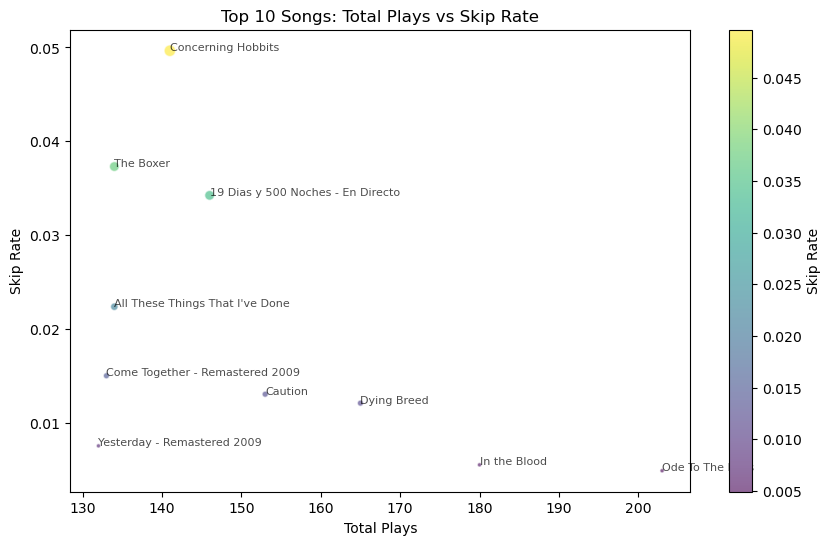

In [13]:
song_play_counts = df.groupby('track_name').agg(
    total_plays=('track_name', 'count'),
    total_skips=('skipped', 'sum'),
    skip_rate=('skipped', 'mean')
).sort_values('total_plays', ascending=False)

top_songs = song_play_counts.head(10).reset_index()

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    top_songs['total_plays'], 
    top_songs['skip_rate'], 
    s=top_songs['total_skips'] * 10,  
    alpha=0.6,
    edgecolors='w',
    c=top_songs['skip_rate'],  
    cmap='viridis'
)

plt.xlabel('Total Plays')
plt.ylabel('Skip Rate')
plt.title('Top 10 Songs: Total Plays vs Skip Rate')
plt.colorbar(scatter, label='Skip Rate')

for i, txt in enumerate(top_songs['track_name']):
    plt.annotate(txt, (top_songs['total_plays'][i], top_songs['skip_rate'][i]), fontsize=8, alpha=0.7)

plt.show()


What time of day do they typically listen to music?

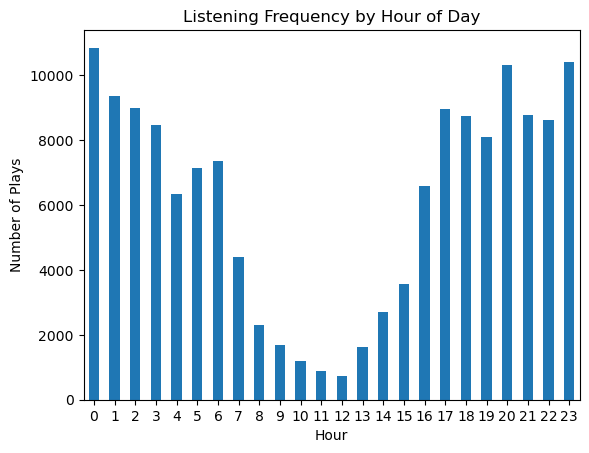

In [14]:
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Listening Frequency by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Plays')
plt.xticks(rotation=0)
plt.show()

How often do they explore new artists vs replaying favorite

New artist plays: 4112 (2.78%)
Repeat artist plays: 143966 (97.22%)


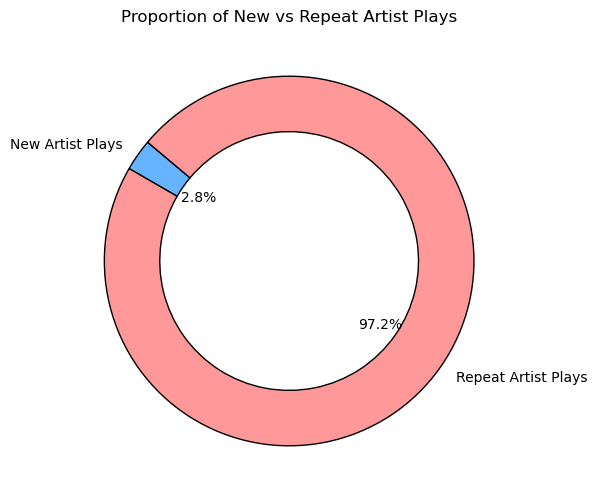

In [15]:
df = df.sort_values('ts')

seen_artists = set()
explore_flags = []

for artist in df['artist_name']:
    if artist in seen_artists:
        explore_flags.append(False) 
    else:
        explore_flags.append(True) 
        seen_artists.add(artist)

df['is_new_artist'] = explore_flags

total_plays = len(df)
new_artist_plays = df['is_new_artist'].sum()
repeat_artist_plays = total_plays - new_artist_plays

print(f"New artist plays: {new_artist_plays} ({new_artist_plays / total_plays:.2%})")
print(f"Repeat artist plays: {repeat_artist_plays} ({repeat_artist_plays / total_plays:.2%})")

labels = ['New Artist Plays', 'Repeat Artist Plays']
sizes = [new_artist_plays, repeat_artist_plays]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor':'black', 'width':0.3})
plt.title('Proportion of New vs Repeat Artist Plays')
plt.show()

In [16]:
df = df.drop(['spotify_track_uri', 'ts', 'track_name', 'artist_name', 'album_name'], axis=1)

In [17]:
label_encoders = {}
categorical_cols = ['platform', 'reason_start', 'reason_end']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [18]:
X = df.drop('skipped', axis=1)
y = df['skipped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree Accuracy: 0.9947325769854133
Classification Report:               precision    recall  f1-score   support

       False       1.00      1.00      1.00     28071
        True       0.95      0.95      0.95      1545

    accuracy                           0.99     29616
   macro avg       0.97      0.97      0.97     29616
weighted avg       0.99      0.99      0.99     29616



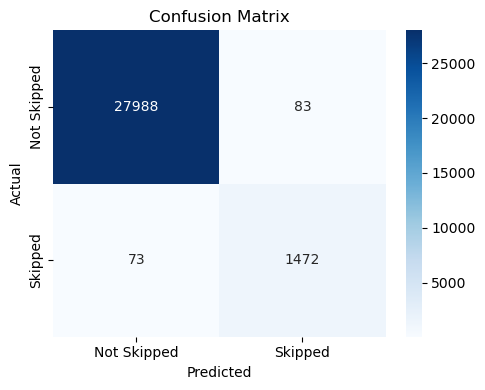

In [19]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:", classification_report(y_test, y_pred_dt))

conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Skipped', 'Skipped'], 
            yticklabels=['Not Skipped', 'Skipped'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Logistic Regression Accuracy: 0.9478997839005943
Classification Report:               precision    recall  f1-score   support

       False       0.95      1.00      0.97     28071
        True       0.52      0.01      0.03      1545

    accuracy                           0.95     29616
   macro avg       0.74      0.51      0.50     29616
weighted avg       0.93      0.95      0.92     29616



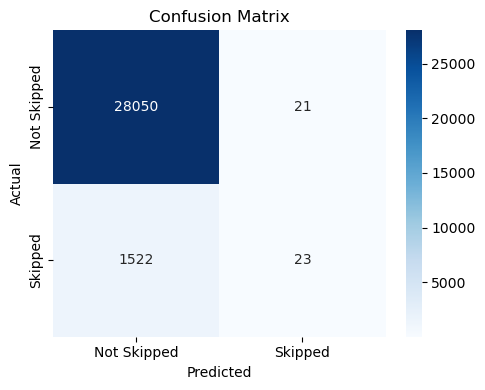

In [20]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=5000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:", classification_report(y_test, y_pred_lr))

conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Skipped', 'Skipped'], 
            yticklabels=['Not Skipped', 'Skipped'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Random Forest Accuracy: 0.9958806050783361
Classification Report:               precision    recall  f1-score   support

       False       1.00      1.00      1.00     28071
        True       0.98      0.94      0.96      1545

    accuracy                           1.00     29616
   macro avg       0.99      0.97      0.98     29616
weighted avg       1.00      1.00      1.00     29616



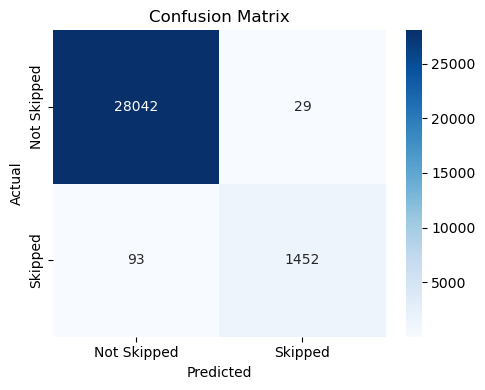

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:", classification_report(y_test, y_pred_rf))

conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Skipped', 'Skipped'], 
            yticklabels=['Not Skipped', 'Skipped'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Gradient Boosting Accuracy: 0.9942598595353863
Classification Report:               precision    recall  f1-score   support

       False       0.99      1.00      1.00     28071
        True       1.00      0.89      0.94      1545

    accuracy                           0.99     29616
   macro avg       0.99      0.95      0.97     29616
weighted avg       0.99      0.99      0.99     29616



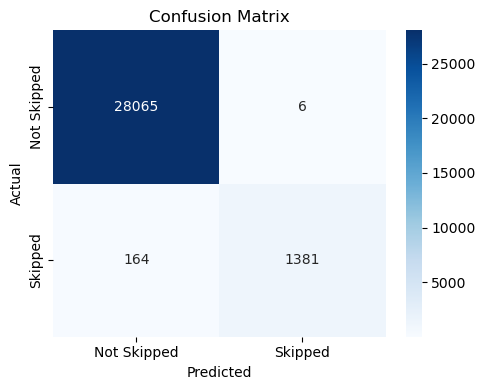

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:", classification_report(y_test, y_pred_gb))

conf_matrix = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Skipped', 'Skipped'], 
            yticklabels=['Not Skipped', 'Skipped'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()